In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from mnist import MNIST
from time import time

In [2]:
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255)
print("Done.")

Loading dataset....
Done.


In [3]:
def one_hot_encode(labels):
    y_inp=np.zeros((len(labels),10))
    for ind,val in enumerate(labels):
        y_inp[ind][val]=1
    return y_inp

In [4]:
def batch_gen(st=0,size=20,validate=False):
    st=st%60000
    if validate:
        X=X_test[st:st+size].reshape(-1,28,28,1)
        labels=y_test[st:st+size]
    else:
        X=X_train[st:st+size].reshape(-1,28,28,1)
        labels=y_train[st:st+size]
    y=one_hot_encode(labels)
    return X,y

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 49
Seed: 426


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128,input_shape=(100),activation=functions.leakyRelu))
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dense(784,activation=functions.tanh))
    return model
g=generator()

In [7]:
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 128)                leakyRelu        12928
__________________________________________________________________________________________
2 dense(dense)            (None, 256)                leakyRelu        33024
__________________________________________________________________________________________
3 dense(dense)            (None, 784)                tanh             201488
Total Params: 247,440
Trainable Params: 247,440
Non-trainable Params: 0


In [8]:
def discriminator():
    model=Sequential()
    model.add(dense(256,input_shape=(784),activation=functions.leakyRelu))
    model.add(dropout(0.3))
    model.add(dense(128,activation=functions.leakyRelu))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()

In [9]:
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 784)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 256)                leakyRelu        200960
__________________________________________________________________________________________
2 dropout(dropout)        (None, 256)                echo             0
__________________________________________________________________________________________
3 dense(dense)            (None, 128)                leakyRelu        32896
__________________________________________________________________________________________
4 dense(dense)            (None, 1)                  sigmoid          129
Total Params: 233,985
Trainable Params: 233,985
Non-trainable Params: 0


In [10]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.001)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

In [12]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    for _b in range(dsz//batch_size):
        stt=time()
        noise=np.random.uniform(-1,1,(batch_size,100))
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=dsz,size=batch_size)]
        X = np.concatenate([real_images,generated_images])
        # Label real ones as 90% real
        y_dis=np.zeros((2*batch_size,1))
        y_dis[:batch_size]=0.99
        # Train discriminator
        d.fit(X,y_dis)
        # Treat noised input of generator as real data
        noise=np.random.uniform(-1,1,(batch_size,100))
        y_gen=np.ones((batch_size,1))
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_fit(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        print("\rProgress: {:.2f} %     Sample time: {:.3f}s    _".format(_b*batch_size*100/dsz,time()-stt),end='')

EPOCH: 1 / 50
Progress: 99.84 %     Sample time: 0.027s    _
Epoch time: 0:29s


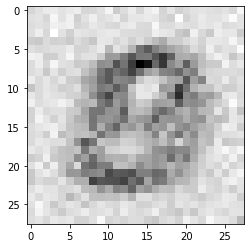

EPOCH: 2 / 50
Progress: 99.84 %     Sample time: 0.032s    _
Epoch time: 0:31s


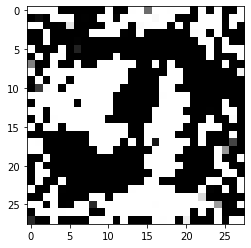

EPOCH: 3 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:35s


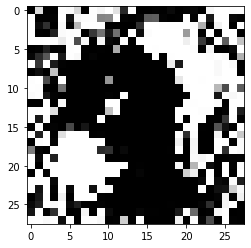

EPOCH: 4 / 50
Progress: 99.84 %     Sample time: 0.028s    _
Epoch time: 0:29s


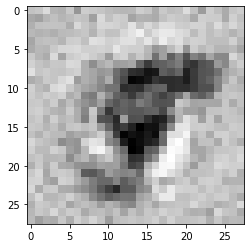

EPOCH: 5 / 50
Progress: 99.84 %     Sample time: 0.028s    _
Epoch time: 0:30s


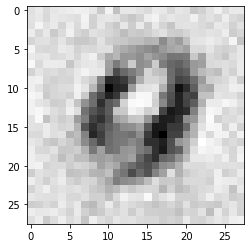

EPOCH: 6 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:33s


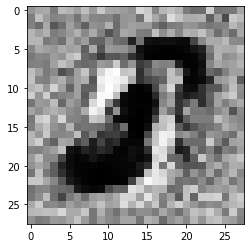

EPOCH: 7 / 50
Progress: 99.84 %     Sample time: 0.031s    _
Epoch time: 0:33s


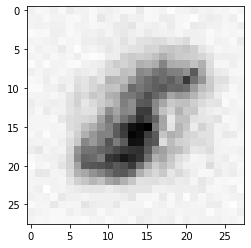

EPOCH: 8 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:42s


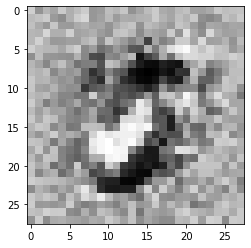

EPOCH: 9 / 50
Progress: 99.84 %     Sample time: 0.028s    _
Epoch time: 0:36s


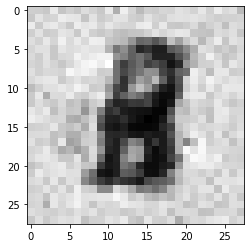

EPOCH: 10 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:29s


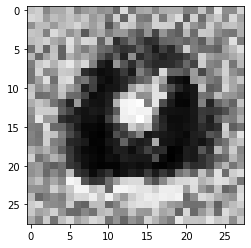

EPOCH: 11 / 50
Progress: 99.84 %     Sample time: 0.044s    _
Epoch time: 0:37s


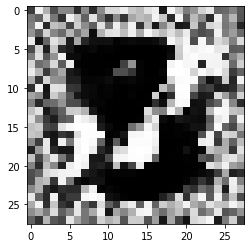

EPOCH: 12 / 50
Progress: 99.84 %     Sample time: 0.028s    _
Epoch time: 0:33s


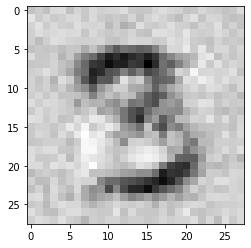

EPOCH: 13 / 50
Progress: 99.84 %     Sample time: 0.046s    _
Epoch time: 0:31s


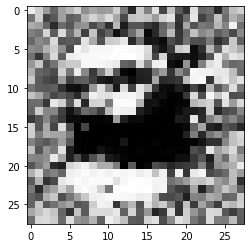

EPOCH: 14 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:31s


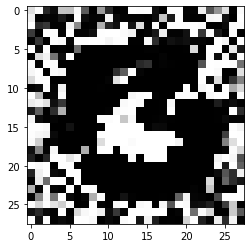

EPOCH: 15 / 50
Progress: 99.84 %     Sample time: 0.049s    _
Epoch time: 0:33s


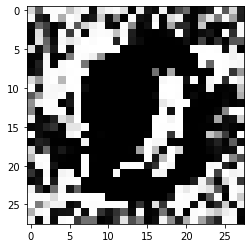

EPOCH: 16 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:33s


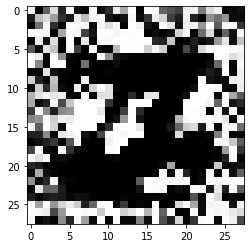

EPOCH: 17 / 50
Progress: 99.84 %     Sample time: 0.030s    _
Epoch time: 0:32s


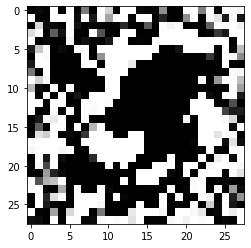

EPOCH: 18 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:31s


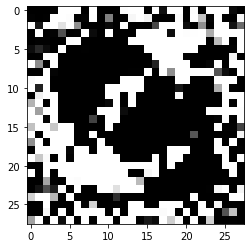

EPOCH: 19 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:32s


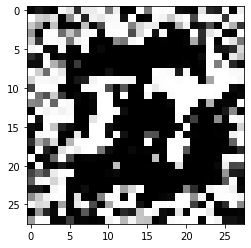

EPOCH: 20 / 50
Progress: 99.84 %     Sample time: 0.030s    _
Epoch time: 0:32s


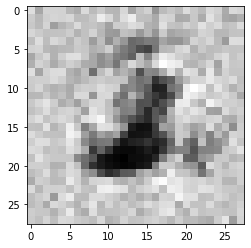

EPOCH: 21 / 50
Progress: 99.84 %     Sample time: 0.029s    _
Epoch time: 0:33s


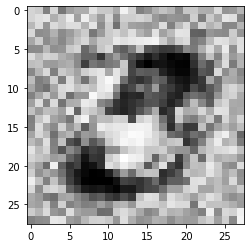

EPOCH: 22 / 50
Progress: 99.84 %     Sample time: 0.030s    _
Epoch time: 0:34s


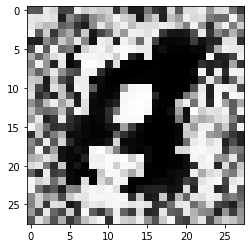

EPOCH: 23 / 50
Progress: 99.84 %     Sample time: 0.032s    _
Epoch time: 0:36s


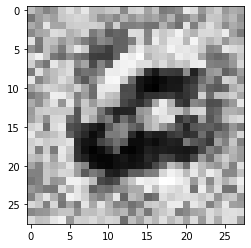

EPOCH: 24 / 50
Progress: 99.84 %     Sample time: 0.032s    _
Epoch time: 0:31s


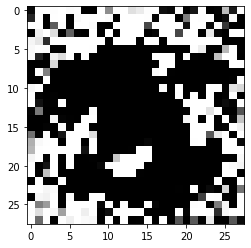

EPOCH: 25 / 50
Progress: 99.84 %     Sample time: 0.030s    _
Epoch time: 0:32s


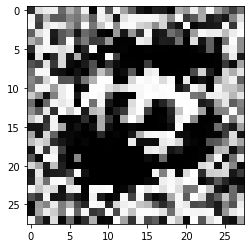

EPOCH: 26 / 50
Progress: 88.21 %     Sample time: 0.103s    _

In [ ]:
epochs=50
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    noise=np.random.uniform(-1,1,(1,100))
    plt.imshow(g.predict(noise).reshape(28,28), cmap='Greys')
    plt.show()

In [ ]:
noise=np.random.uniform(-1,1,(1,100))
plt.imshow(g.predict(noise).reshape(28,28), cmap='Greys')
plt.show()

In [268]:
noise=np.random.uniform(-1,1,(64,100))
gout=g.forward(noise)
# do not train discriminator and find delta for generator
y_gen=np.ones((64,1))
dout,err=d.not_fit(gout,y_gen)
g.backprop(err,g.lenseq_m1)
g.optimizer(g.sequence,g.learning_rate,g.beta)